PARAMETERS DEFINED FOR SIMULATION

In [7]:
#parameters definition:
Nr = 1000
Nb = 1000
jr = 0.5
jb = 0.5
#mr described as degree of connection (not number of neighbors)
mr = 1
mb = 1
#size of the grid (LxL)
L = 100
animation_name = "schelling_anim"

In [6]:
S = Schelling(Nb, Nr, jb, jr, mr, mb, L)
similarity_index, number_of_MC_steps = S.simulate()
#create_animation
S.simulate_and_save_animation(animation_name)

In [2]:
import numpy as np
from matplotlib import pyplot as plt, animation
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
class Schelling():
    def __init__(self, Nb, Nr, jb, jr, mr, mb, L=100):
        #1 - blue; 2 - red
        self.L = L
        self.N = Nb + Nr
        self.Nb = Nb
        self.Nr = Nr
        self.jb = jb
        self.jr = jr
        self.mb = mb
        self.mr = mr
        self.state = np.zeros(self.L*self.L)
        self.agents_positions = []
    
    def get_neighbors(self, pos):
        x, y = pos
        if (self.state[pos[0], pos[1]] == 1) or (self.mb == self.mr):
            neighbor_positions = [(i % self.L, j % self.L) for i in range(x-self.mb, x+self.mb+1)
                                  for j in range(y-self.mb, y+self.mb+1) if (i, j) != (x, y)]
        else:
            neighbor_positions = [(i % self.L, j % self.L) for i in range(x-self.mr, x+self.mr+1)
                                  for j in range(y-self.mr, y+self.mr+1) if (i, j) != (x, y)]
            
        return neighbor_positions
    
    def initiate_model(self):
        self.state = np.zeros(self.L*self.L)
        length = len(self.state)
        indices = np.random.choice(list(range(length)), size=self.Nb+self.Nr, replace=False)
        self.state[indices[0:self.Nb]] = 1
        self.state[indices[self.Nb:]] = 2
        self.state = np.reshape(self.state, (self.L, self.L))
        
    def get_agents(self):
        row_indices, col_indices = np.where(self.state != 0)
        self.agents_positions = list(zip(row_indices, col_indices))
        
    def calculate_SNI(self, agent_position, agent_state):
        agent_neighbors = self.get_neighbors(agent_position)
        neighbors_opinions = [self.state[pos[0], pos[1]] for pos in agent_neighbors]
        vals, counts = np.unique(neighbors_opinions, return_counts=True)
        states_dict = dict(zip(vals, counts))
        
        contrary_state = 1 if agent_state == 2 else 2
        values = list(states_dict.values())[1:] if 0 in states_dict else list(states_dict.values())
        if sum(values) == 0 or agent_state not in states_dict:
            return 0
        return states_dict[agent_state]/sum(values)
        
    def simulate(self):
        self.initiate_model()
        self.get_agents()
        
        all_satisfied = False
        number_of_MC_steps = 0
        
        while not all_satisfied:
            number_of_MC_steps += 1
            for i in range(self.N):
                agent_index = np.random.randint(len(self.agents_positions))
                agent_position = self.agents_positions[agent_index]
                agent_state = self.state[agent_position[0], agent_position[1]]
                
                SNI = self.calculate_SNI(agent_position, agent_state)
                
                if (agent_state == 1 and SNI < self.jb) or (agent_state == 2 and SNI < self.jr):
                    new_index = np.random.randint(self.L, size=2)
                    while self.state[new_index[0], new_index[1]] != 0:
                        new_index = np.random.randint(self.L, size=2)
                    self.state[agent_position[0], agent_position[1]] = 0
                    self.state[new_index[0], new_index[1]] = agent_state
                    self.agents_positions[agent_index] = tuple(new_index)
                    
            unsatisfied_agents = False
            segregation_index = 0
            for i, agent_position in enumerate(self.agents_positions):
                agent_state = self.state[agent_position[0], agent_position[1]]
                SNI = self.calculate_SNI(agent_position, agent_state)
                segregation_index += SNI
                if (agent_state == 1 and SNI < self.jb) or (agent_state == 2 and SNI < self.jr):
                    unsatisfied_agents = True
                    break
            
            if not unsatisfied_agents:
                all_satisfied = True
                
        return segregation_index/self.N, number_of_MC_steps
    
    def simulate_and_save_animation(self, animation_name="anim"):
        self.initiate_model()
        self.get_agents()
        
        all_satisfied = False
        number_of_MC_steps = 0
        
        animation_states = self.state
        while not all_satisfied:
            animation_states = np.vstack([animation_states, self.state])
            
            for i in range(self.N):
                agent_index = np.random.randint(len(self.agents_positions))
                agent_position = self.agents_positions[agent_index]
                agent_state = self.state[agent_position[0], agent_position[1]]
                
                SNI = self.calculate_SNI(agent_position, agent_state)
                
                if (agent_state == 1 and SNI < self.jb) or (agent_state == 2 and SNI < self.jr):
                    new_index = np.random.randint(self.L, size=2)
                    while self.state[new_index[0], new_index[1]] != 0:
                        new_index = np.random.randint(self.L, size=2)
                    self.state[agent_position[0], agent_position[1]] = 0
                    self.state[new_index[0], new_index[1]] = agent_state
                    self.agents_positions[agent_index] = tuple(new_index)
                    
            unsatisfied_agents = False
            segregation_index = 0
            for i, agent_position in enumerate(self.agents_positions):
                agent_state = self.state[agent_position[0], agent_position[1]]
                SNI = self.calculate_SNI(agent_position, agent_state)
                segregation_index += SNI
                if (agent_state == 1 and SNI < self.jb) or (agent_state == 2 and SNI < self.jr):
                    unsatisfied_agents = True
                    break
            
            if not unsatisfied_agents:
                all_satisfied = True
        animation_states = np.vstack([animation_states, self.state])
        create_animation(self.clean_results(animation_states), animation_name)
    
    def clean_results(self, res):
        new_res = list(np.zeros(int(len(res)/self.L-1)))
        for i in range(len(new_res)):
            new_res[i] = res[int((i+1)*self.L): int((i+2)*self.L)]
        return new_res

In [4]:
def create_animation(data, animation_name):
    fig = plt.figure()
    sns.heatmap(data[0], square=True, cbar=False, cmap=ListedColormap(['white', 'blue', 'red']), yticklabels=False, xticklabels=False)

    def init():
        sns.heatmap(data[0], square=True, cbar=False, cmap=ListedColormap(['white', 'blue', 'red']), yticklabels=False, xticklabels=False)

    def animate(i):
        sns.heatmap(data[i], square=True, cbar=False, cmap=ListedColormap(['white', 'blue', 'red']), yticklabels=False, xticklabels=False)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(data), repeat = False)
    anim.save(f'images/{animation_name}.gif')

In [20]:
Nb = Nr = 1000
jb1 = jr1 = 1/2
mb = mr = 1
jb2 = 3/8
jr2 = 6/8

In [21]:
S1 = Schelling(Nb, Nr, jb1, jr1, mr, mb, 100)

MovieWriter ffmpeg unavailable; using Pillow instead.


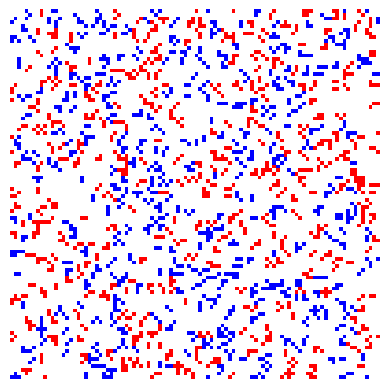

In [22]:
S1.simulate_and_save_animation("anim_N_1000_j_05_m_1")

In [23]:
S2 = Schelling(1000, 1000, jb2, jr2, mr, mb, 100)

MovieWriter ffmpeg unavailable; using Pillow instead.


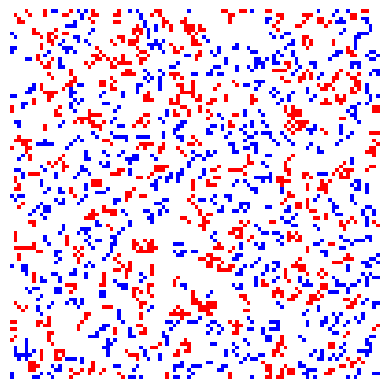

In [24]:
S2.simulate_and_save_animation("anim_N_1000_jb_38_jr_68_m_1")

# Created animations

$N_b\text{, }N_r = 3000$

$j_b\text{, }j_r = 0.5$

<img src="images/anim_N_3000_j_05_m_1.gif" width="750" align="center">

$j_b = \frac{3}{8}$, $j_r = \frac{6}{8}$

<img src="images/anim_N_3000_jb_38_jr_68_m_1.gif" width="750" align="center">

$N_b\text{, }N_r = 1000$

$j_b\text{, }j_r = 0.5$

<img src="images/anim_N_1000_j_05_m_1.gif" width="750" align="center">

$j_b = \frac{3}{8}$, $j_r = \frac{6}{8}$

<img src="images/anim_N_1000_jb_38_jr_68_m_1.gif" width="750" align="center">

## Number of iterations

In [248]:
def num_of_iterations(Ns, m=1, j=0.5, num_of_simulations=100):
    results = np.zeros(len(Ns))
    for i, N in enumerate(Ns):
        for _ in range(num_of_simulations):
            S2 = Schelling(N, N, j, j, m, m, 100)
            results[i] += S2.simulate()[1]
        results[i] /= num_of_simulations
    return results

In [39]:
Ns = np.arange(250, 4250, 250)
j = 0.5
m=1
num_of_simulations = 100

In [20]:
results = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    print(N)
    for _ in range(num_of_simulations):
        S2 = Schelling(N, N, j, j, m, m, 100)
        results[i] += S2.simulate()[1]
    results[i] /= num_of_simulations

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750


In [41]:
print(results)

[50.47, 30.94, 24.19, 21.04, 18.91, 19.11, 18.51, 18.5, 19.63, 19.24, 19.48, 20.85, 21.61, 21.47, 22.82, 23.78]


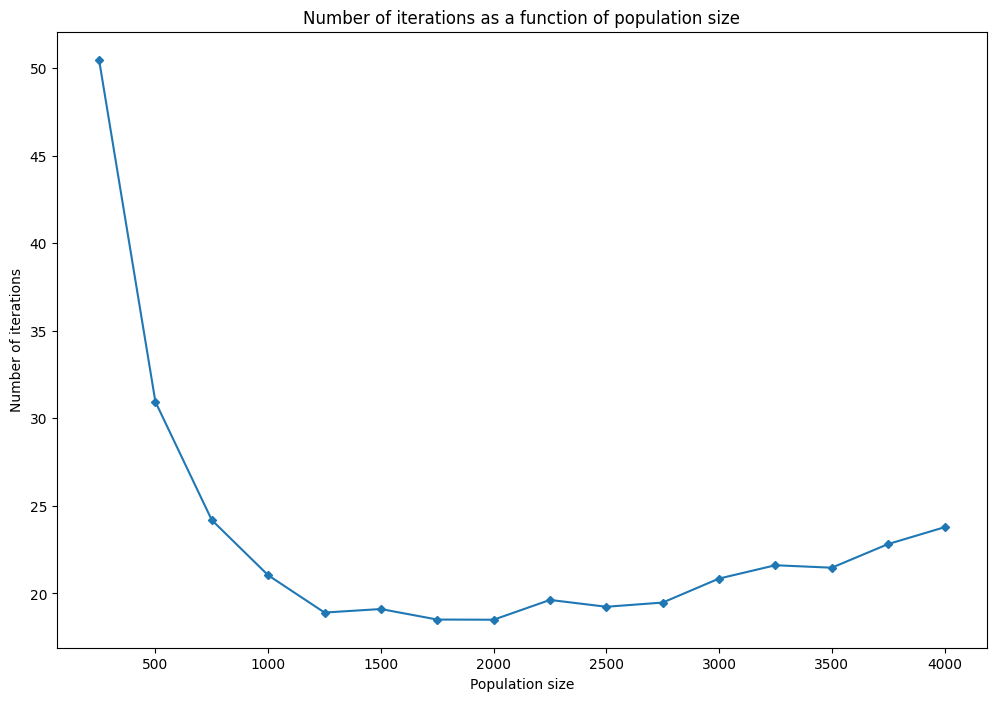

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(Ns, results, marker='D', markersize=4)
plt.title("Number of iterations as a function of population size")
plt.xlabel("Population size")
plt.ylabel("Number of iterations")
plt.savefig('images/mc_steps3.png')

## Segregation index

#### As a function of $j_{t}$

In [52]:
js = np.arange(0.1, 1, 0.1)
N = 1000
m=1
num_of_simulations = 100

In [45]:

segregation_index1 = np.zeros(len(js))
for i, jt in enumerate(js):
    print(jt)
    for _ in range(num_of_simulations):
        S2 = Schelling(N, N, jt, jt, m, m, 100)
        segregation_index1[i] += S2.simulate()[0]
    segregation_index1[i] /= num_of_simulations


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


KeyboardInterrupt: 

Case for $j = 0.9$, where the simulations didn't end for long time.

In [53]:
s09 = 0
for _ in range(num_of_simulations):
    S2 = Schelling(N, N, 0.9, 0.9, m, m, 100)
    s09 += S2.simulate()[0]
s09 /= num_of_simulations

KeyboardInterrupt: 

In [ ]:
s09

In [46]:
segregation_index1

array([0.80405146, 0.80762149, 0.86536167, 0.93849546, 0.9438825 ,
       0.99281695, 0.99945617, 0.999978  , 0.        ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


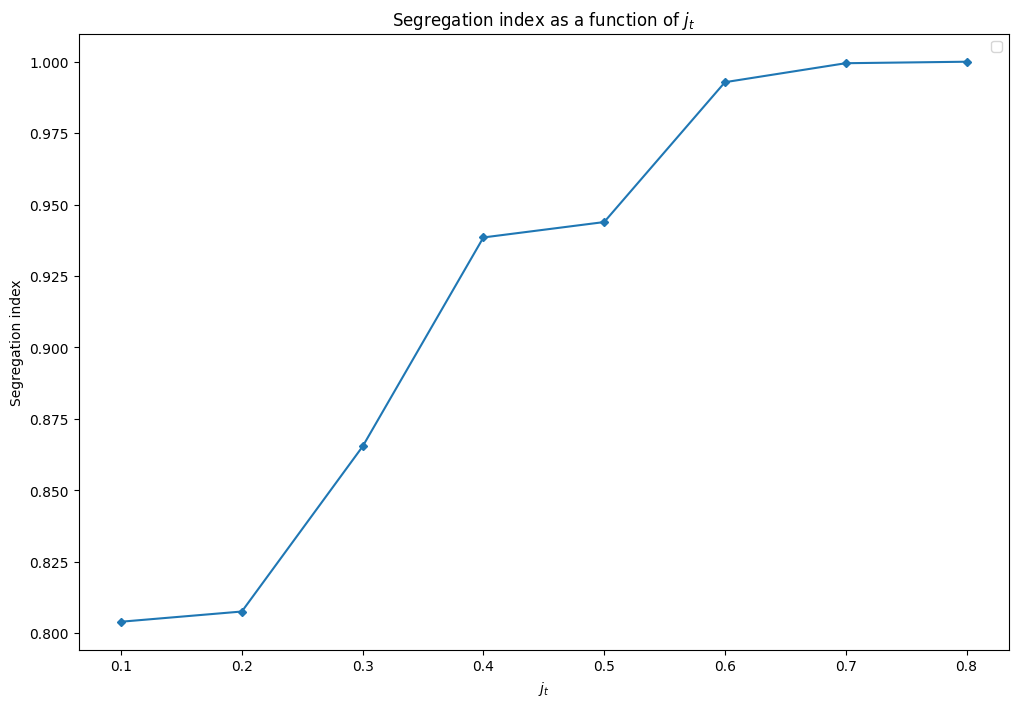

In [47]:
plt.figure(figsize=(12, 8))
plt.plot(js[:-1], segregation_index1[:-1], marker='D', markersize=4)
plt.legend()
plt.title(r"Segregation index as a function of $j_{t}$")
plt.xlabel(r"$j_{t}$")
plt.ylabel("Segregation index")
plt.savefig('images/segregation_index_j.png')

#### As a function of $m_t$

In [49]:
ms = np.array([1, 2, 3, 4, 5])
j = 0.5
N = 1000

In [50]:
segregation_index_m1 = np.zeros(len(ms))
for i, mt in enumerate(ms):
    print(mt)
    for _ in range(num_of_simulations):
        S2 = Schelling(N, N, j, j, mt, mt, 100)
        segregation_index_m1[i] += S2.simulate()[0]
    segregation_index_m1[i] /= num_of_simulations

1
2
3
4
5


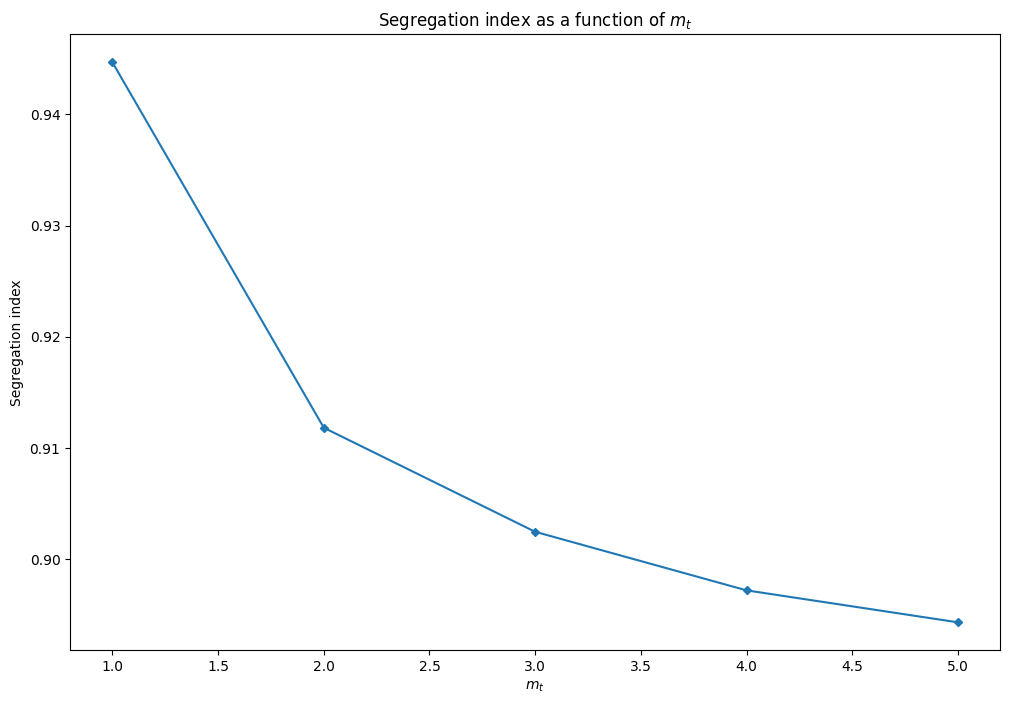

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(ms, segregation_index_m1, marker='D', markersize=4)
plt.title(r"Segregation index as a function of $m_{t}$")
plt.xlabel(r"$m_{t}$")
plt.ylabel("Segregation index")
plt.savefig('images/segregation_index_m.png')